In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def prep_data(df):
    df = clean_data(df)
    df = preprocess_data(df)
    return df

def clean_data(df):
    
    # set column names as first row
    rename_map = dict([(old_name, new_name) for old_name, new_name in zip(df.axes[1], list(df.iloc[0]))])
    df = df.rename(rename_map, axis=1)

    # remove diagnostic/treatments stuff as no values for healthy participants and first row (which held the column names)
    df = pd.concat([df.iloc[:,1:4], df.iloc[:,33:]], axis=1)[1:]

    # Convert category (ALS or HC) to binary so don't have to predict a string lol
    binary_target = df["Category"] == "ALS"
    df["Category"] = binary_target

    # One-hot encode gender
    is_male = df["Sex"] == "M"
    df["gender_male"] = is_male.astype(int)
    df["gender_female"] = 1 - is_male
    df = df.drop(columns="Sex")

    return df

def preprocess_data(df):

    # numeric features that need standardizing
    numeric_features = ["Age (years)", "meanF0Hz_A", "stdevF0Hz_A", "HNR_A", "localJitter_A", "localShimmer_A", "meanF0Hz_E", "stdevF0Hz_E", "HNR_E", "localJitter_E", "localShimmer_E", "meanF0Hz_I", "stdevF0Hz_I", "HNR_I", "localJitter_I", "localShimmer_I", "meanF0Hz_O", "stdevF0Hz_O", "HNR_O", "localJitter_O", "localShimmer_O", "meanF0Hz_U", "stdevF0Hz_U", "HNR_U", "localJitter_U", "localShimmer_U", "meanF0Hz_PA", "stdevF0Hz_PA", "HNR_PA", "localJitter_PA", "localShimmer_PA", "meanF0Hz_TA", "stdevF0Hz_TA", "HNR_TA", "localJitter_TA", "localShimmer_TA", "meanF0Hz_KA", "stdevF0Hz_KA", "HNR_KA", "localJitter_KA", "localShimmer_KA", "meanF0Hz_monologue", "stdevF0Hz_monologue", "HNR_monologue", "localJitter_monologue", "localShimmer_monologue", "meanF0Hz_reading", "stdevF0Hz_reading", "HNR_reading", "localJitter_reading", "localShimmer_reading", "meanF0Hz_weekdays", "stdevF0Hz_weekdays", "HNR_weekdays", "localJitter_weekdays", "localShimmer_weekdays", "Cantagallo_Questionnaire"]  # numerical columns
    onehot_features = ["Category", 'gender_male', 'gender_female'] # no touchy

    # standardize numeric features (not ALS diagnosis, or one hot encoded gender)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', 'passthrough', onehot_features)  # passthrough = no touchy
        ]
    )

    p = Pipeline(steps=[
        ('preprocessor', preprocessor)])

    scaled_data = p.fit_transform(df)

    # Convert back to DataFrame
    all_feature_names = numeric_features + onehot_features
    df = pd.DataFrame(scaled_data, columns=all_feature_names, index=df.index)

    # Make everything numeric
    for name in df.columns:
        df[name] = pd.to_numeric(df[name], errors='coerce')

    return df

df = prep_data(pd.read_excel('VOC-ALS.xlsx'))
df.head()

,Age (years),meanF0Hz_A,stdevF0Hz_A,HNR_A,localJitter_A,localShimmer_A,meanF0Hz_E,stdevF0Hz_E,HNR_E,localJitter_E,...,localShimmer_reading,meanF0Hz_weekdays,stdevF0Hz_weekdays,HNR_weekdays,localJitter_weekdays,localShimmer_weekdays,Cantagallo_Questionnaire,Category,gender_male,gender_female
1,-0.596545,0.780900,-0.854556,0.112354,-0.586274,1.340078,0.864894,-0.639528,-0.397213,-0.497281,...,0.251266,0.526677,-0.498159,0.134135,-0.752233,0.237306,-0.712214,False,0,1
2,0.799575,0.943590,-0.677661,1.474616,-0.658861,-0.793134,0.814170,-0.546830,1.355740,-0.601093,...,-1.561406,1.257791,0.343883,1.970252,-1.514839,-1.727805,-0.944415,False,0,1
3,-0.247515,-0.245186,-0.674186,-0.648526,-0.186461,-0.562193,-0.738366,-0.406278,-2.032928,1.909601,...,-0.970929,-0.468445,-0.617694,0.757799,-0.149436,-0.801535,-0.214640,False,0,1
4,0.101515,1.049131,0.518163,0.449962,-0.464083,0.167784,0.425198,1.272075,0.532107,-0.530237,...,0.276340,1.279800,-0.446608,0.232726,0.399517,0.587947,-0.546356,False,0,1
5,-0.073000,0.925208,0.064061,1.160927,-0.259407,-0.673165,1.179024,-0.737717,0.627439,-0.576983,...,-0.165096,0.961817,0.680624,-0.024464,0.637189,0.645913,-0.844900,False,0,1


In [3]:
# Split data into training, testing, and validation sets with a 60/20/20 split
train_set, test_set = train_test_split(df, test_size=0.4, random_state=42)
test_set, val_set = train_test_split(test_set, test_size=0.5, random_state=42)

train_X = train_set.drop(columns="Category")
train_y = train_set["Category"]

test_X = test_set.drop(columns="Category")
test_y = test_set["Category"]

val_X = val_set.drop(columns="Category")
val_y = val_set["Category"]

Text(0, 0.5, 'Explained Variance')

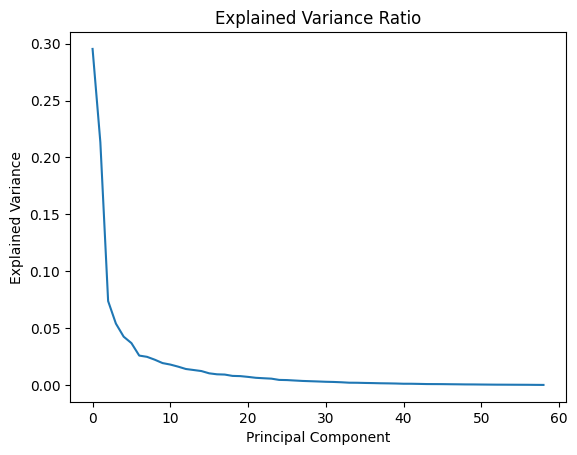

In [11]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(train_X)
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained Variance Ratio")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")

In [5]:
pca_train = pca.transform(train_X)
pca_test = pca.transform(test_X)
pca_val = pca.transform(val_X)

pca_train.shape

(91, 59)

In [6]:
from sklearn.linear_model import LogisticRegression

scores = []

for i in range(pca_train.shape[1] - 1):
    reg = LogisticRegression().fit(pca_train[:,:i + 1], train_y)
    preds = reg.predict(pca_test[:,:i+1])
    scores.append(fbeta_score(test_y, preds, beta=2))

0


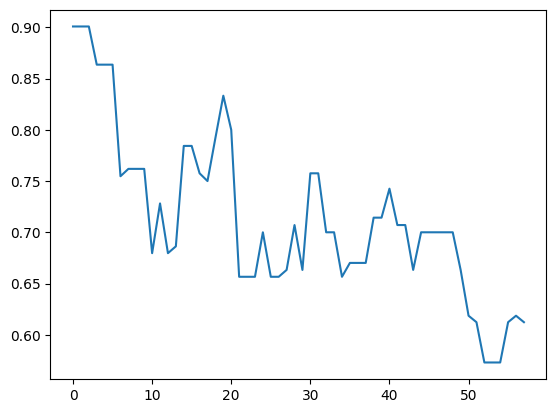

In [7]:
plt.plot(scores)
print(np.argmax(scores))

In [8]:
reg = LogisticRegression().fit(pca_train[:,:20], train_y)
preds = reg.predict(pca_val[:,:20])
print(f"{fbeta_score(val_y, preds, beta=2) = }")
print(f"{precision_score(val_y, preds) = }")
print(f"{recall_score(val_y, preds) = }")

fbeta_score(val_y, preds, beta=2) = 0.9134615384615384
precision_score(val_y, preds) = 0.7916666666666666
recall_score(val_y, preds) = 0.95


In [10]:
reg = LogisticRegression().fit(pca_train[:,:10], train_y)
preds = reg.predict(pca_val[:,:10])
print(f"{fbeta_score(val_y, preds, beta=2) = }")
print(f"{precision_score(val_y, preds) = }")
print(f"{recall_score(val_y, preds) = }")

fbeta_score(val_y, preds, beta=2) = 0.8878504672897196
precision_score(val_y, preds) = 0.7037037037037037
recall_score(val_y, preds) = 0.95
